# Implementation of "Fair Decisions Despite Imperfect Predictions" using the original fairness constraint

In [1]:
import numpy as np
from src.consequential_learning import train
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity

## The parameters used by the the original authors  
Note: Learning rate decay is not yet implemented

In [7]:
training_parameters = {
    'dim_x': 1,
    'dim_s': None,
    'time_steps':200,
    'batch_size':512,
    'num_iterations': 32,
    'learning_parameters': {
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30
    },
    'fairness_rate':1,
    'fraction_protected':0.3,
    'num_test_samples': 5000,
    'bias': True,
    'benefit_value_function': demographic_parity
}
training_parameters['dim_x'] = training_parameters['dim_x'] + 1 if training_parameters['bias'] else training_parameters['dim_x']
dim_theta = training_parameters['dim_x'] + training_parameters['dim_s'] if training_parameters['dim_s'] else training_parameters['dim_x']
training_parameters['feature_map'] = IdentityFeatureMap(dim_theta)
training_parameters['num_decisions'] = training_parameters['num_iterations'] * training_parameters['batch_size']
training_parameters['utility_value_function'] = lambda **util_params : cost_utility(cost_factor=0.55, **util_params)

## Definition of the fairness function  
The original fairness constraint was defined as the difference of benefits $b_{P}^s$ for both of the settings of the protected attribute. This function defines both the fairness function as well as its derivative which is controlled by the parameter gradient=true/false

In [8]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    y = fairness_kwargs["y"]
    s = fairness_kwargs["s"]
    decisions = fairness_kwargs["decisions"]
    gradient = fairness_kwargs["gradient"]
    sampling_theta = fairness_kwargs["sampling_theta"]

    return policy._benefit_difference(x, s, y, decisions, gradient, sampling_theta)

training_parameters['fairness_function'] = fairness_function

## Train the model

In [13]:
i = 1
utilities = []
benefit_deltas = []

for _, utility, benefit_delta in train(**training_parameters):
    utilities.append(utility)
    benefit_deltas.append(benefit_delta)
    i += 1

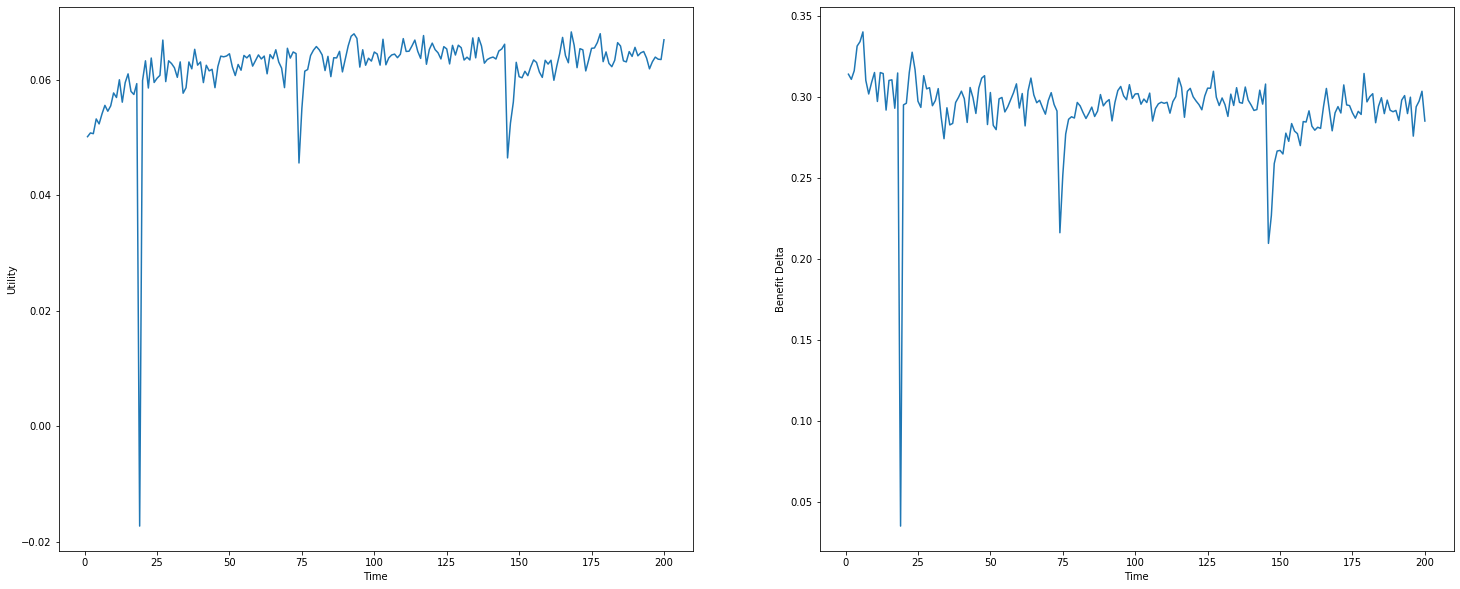

In [14]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(25,10))
ax1.plot(range(1, len(utilities) + 1), utilities)
ax1.set_xlabel("Time")
ax1.set_ylabel("Utility")
ax2.plot(range(1, len(benefit_deltas) + 1), benefit_deltas)
ax2.set_xlabel("Time")
ax2.set_ylabel("Benefit Delta")
plt.show()